In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.model_selection import train_test_split



In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_training-set.csv')
num_features = len(data.columns)

In [ ]:
num_features

45

In [ ]:
data.head(9999)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,1.185800,tcp,-,FIN,10,8,564,354,14.336314,...,1,1,0,0,0,1,1,0,Reconnaissance,1
9995,9996,0.932214,tcp,-,FIN,14,10,1430,2272,24.672446,...,1,1,0,0,0,1,1,0,DoS,1
9996,9997,1.112387,tcp,smtp,FIN,72,28,69845,2076,88.997808,...,1,1,0,0,0,18,1,0,Exploits,1
9997,9998,0.931772,tcp,http,FIN,10,8,798,1212,18.244807,...,1,2,0,0,1,1,1,0,DoS,1


In [ ]:
categorical_features = ['proto','service','state']
numerical_features = data.drop(columns = [ 'id' , 'proto' , 'service' , 'state', 'attack_cat']).columns

In [ ]:
encoder = OneHotEncoder(sparse_output = False , drop = 'first')
encoder_categorical = encoder.fit_transform(data[categorical_features])

In [ ]:
scalar = StandardScaler()
scaled_numerical = scalar.fit_transform(data[numerical_features])

In [ ]:
X_prepared = np.hstack((encoder_categorical , scaled_numerical))


In [ ]:
y = data['attack_cat'].values

Embedded model creation

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class EmbeddedNetwork(nn.Module):
  def __init__(self , input_dim , embedding_dim=128 ):
    super(EmbeddedNetwork , self).__init__()

    #i/p layer -> hidden layer 512neurons
    self.fc1 = nn.Linear(input_dim , 512)
    self.relu1 = nn.ReLU()

    #i/p layer -> hidden layer 256neurons
    self.fc2 = nn.Linear(512 , 256)
    self.relu2 = nn.ReLU()

    #i/p layer -> hidden layer 128 neurons
    self.fc3 = nn.Linear(256 , 128)
    self.relu3 = nn.ReLU()

    #HL3 -> embedding layer of the embedding_data
    self.fc4 = nn.Linear(128 , embedding_dim)

  def forward(self , x):

    x=self.fc1(x)
    x=self.relu1(x)

    x=self.fc2(x)
    x=self.relu2(x)

    x=self.fc3(x)
    x=self.relu3(x)

    x=self.fc4(x)

    return x

In [ ]:

input_dim = X_prepared.shape[1]  # Match input dimension with the prepared data
embedding_dim = 256
model = EmbeddedNetwork(input_dim, embedding_dim)

Overview of the Next Steps:
*   Positive and Negative Pairs
*   InfoNCE
*   Training loop

In [ ]:
import random

def create_pairs(data, labels):
    positive_pairs = []
    negative_pairs = []

    for i in range(len(data)):
        x_i = data[i]
        label_i = labels[i]

        # Positive pair selection
        positive_indices = np.where(labels == label_i)[0].tolist()
        positive_indices.remove(i)
        if positive_indices:
            positive_idx = random.choice(positive_indices)
            x_j = data[positive_idx]
            positive_pairs.append((x_i, x_j))

        # Negative pair selection
        negative_indices = np.where(labels != label_i)[0].tolist()
        if negative_indices:
            negative_idx = random.choice(negative_indices)
            x_k = data[negative_idx]
            negative_pairs.append((x_i, x_k))

    return positive_pairs, negative_pairs


In [ ]:
"""
    Compute the contrastive loss using InfoNCE.

    Args:
    - positive_pairs: List of positive pairs of samples
    - negative_pairs: List of negative pairs of samples
    - model: The embedding network
    - temperature: A hyperparameter that controls the scaling of the similarities

    Returns:
    - loss: The contrastive loss
"""
import torch.nn.functional as F

def contrastive_loss(pos_x_i, pos_x_j, neg_x_i, neg_x_k, model, temperature=0.5, alpha=0.6):
    embedded_pos_i = model(pos_x_i)
    embedded_pos_j = model(pos_x_j)
    embedded_neg_i = model(neg_x_i)
    embedded_neg_k = model(neg_x_k)

    # Compute cosine similarities with temperature scaling
    sim_pos = F.cosine_similarity(embedded_pos_i, embedded_pos_j) / temperature
    sim_neg = F.cosine_similarity(embedded_neg_i, embedded_neg_k) / temperature

    # Positive pair loss
    pos_loss = -torch.log(torch.exp(sim_pos) / (torch.exp(sim_pos) + 1))

    # Negative pair loss
    neg_loss = -torch.log(1 / (torch.exp(sim_neg) + 1))

    # Weighted contrastive loss
    loss = alpha * pos_loss.mean() + (1 - alpha) * neg_loss.mean()

    return loss


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

def train_models(data, labels, model, epochs=11):
    data = torch.tensor(data, dtype=torch.float32)
    model.train()

    for epoch in range(epochs):
        positive_pairs, negative_pairs = create_pairs(data.numpy(), labels)

        # Convert pairs to tensors
        pos_x_i = torch.tensor(np.array([pair[0] for pair in positive_pairs]), dtype=torch.float32)
        pos_x_j = torch.tensor(np.array([pair[1] for pair in positive_pairs]), dtype=torch.float32)
        neg_x_i = torch.tensor(np.array([pair[0] for pair in negative_pairs]), dtype=torch.float32)
        neg_x_k = torch.tensor(np.array([pair[1] for pair in negative_pairs]), dtype=torch.float32)

        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = contrastive_loss(pos_x_i, pos_x_j, neg_x_i, neg_x_k, model)

        # Backpropagation
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

        scheduler.step()

# Run training
train_models(X_prepared, y, model, epochs=30)


Epoch 1/30, Loss: 0.9014606475830078
Epoch 2/30, Loss: 0.8409103751182556
Epoch 3/30, Loss: 0.7546203136444092
Epoch 4/30, Loss: 0.6672807931900024
Epoch 5/30, Loss: 0.6145315766334534
Epoch 6/30, Loss: 0.5876576900482178
Epoch 7/30, Loss: 0.5863531827926636
Epoch 8/30, Loss: 0.580628514289856
Epoch 9/30, Loss: 0.5766438245773315
Epoch 10/30, Loss: 0.574583113193512
Epoch 11/30, Loss: 0.5727930068969727
Epoch 12/30, Loss: 0.5705503821372986
Epoch 13/30, Loss: 0.5693957209587097
Epoch 14/30, Loss: 0.5678739547729492
Epoch 15/30, Loss: 0.5724506378173828
Epoch 16/30, Loss: 0.5708383917808533
Epoch 17/30, Loss: 0.56992506980896
Epoch 18/30, Loss: 0.5698205232620239
Epoch 19/30, Loss: 0.568732738494873
Epoch 20/30, Loss: 0.570582926273346
Epoch 21/30, Loss: 0.5715108513832092
Epoch 22/30, Loss: 0.5694654583930969
Epoch 23/30, Loss: 0.5711228847503662
Epoch 24/30, Loss: 0.5683185458183289
Epoch 25/30, Loss: 0.5695347785949707


In [ ]:
data_test  = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_testing-set.csv')

In [ ]:
categorical_features = ['proto','service','state']
numerical_features = data_test.drop(columns = [ 'id' , 'proto' , 'service' , 'state', 'attack_cat']).columns

In [ ]:
encoder = OneHotEncoder(sparse_output = False , drop = 'first')
encoder_categorical = encoder.fit_transform(data[categorical_features])

In [ ]:
scalar = StandardScaler()
scaled_numerical = scalar.fit_transform(data[numerical_features])

In [ ]:
X_test = np.hstack((encoder_categorical , scaled_numerical))

In [ ]:
X_test = X_test[:82332]

In [ ]:
y_test = data_test['attack_cat'].values

In [ ]:
y_test = y_test[:82332]

In [ ]:
from sklearn.metrics import accuracy_score

def test_model(test_data, test_labels, model, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Convert test data to tensor if it's not already a tensor
        test_data = torch.tensor(test_data, dtype=torch.float32)

        # Generate positive and negative pairs from the test data
        test_positive_pairs, test_negative_pairs = create_pairs(test_data.numpy(), test_labels)

        # Extract input pairs for positive and negative samples
        test_pos_x_i = torch.tensor(np.array([pair[0] for pair in test_positive_pairs]), dtype=torch.float32)
        test_pos_x_j = torch.tensor(np.array([pair[1] for pair in test_positive_pairs]), dtype=torch.float32)
        test_neg_x_i = torch.tensor(np.array([pair[0] for pair in test_negative_pairs]), dtype=torch.float32)
        test_neg_x_k = torch.tensor(np.array([pair[1] for pair in test_negative_pairs]), dtype=torch.float32)

        # Calculate test loss using the contrastive loss function
        test_loss = contrastive_loss(test_pos_x_i, test_pos_x_j, test_neg_x_i, test_neg_x_k, model)
        print(f"Test Loss: {test_loss.item()}")

        # Compute similarity scores between positive and negative pairs
        pos_scores = compute_similarity(test_pos_x_i, test_pos_x_j, model)
        neg_scores = compute_similarity(test_neg_x_i, test_neg_x_k, model)

        # Predict using a threshold: 1 for positive pairs, 0 for negative pairs
        pos_predictions = [1 if score > threshold else 0 for score in pos_scores]
        neg_predictions = [0 if score > threshold else 1 for score in neg_scores]

        # Combine predictions from both positive and negative pairs
        predictions = pos_predictions + neg_predictions

        # True labels for validation: 1 for positive, 0 for negative
        true_labels = [1] * len(pos_predictions) + [0] * len(neg_predictions)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

        return accuracy, test_loss


In [ ]:
# # Assuming the model expects inputs with 188 features
# if X_test.shape[1] != 188:
#     X_test = X_test[:, :188]  # Truncate or reshape to match expected size


In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
import torch.nn.functional as F

def compute_similarity(embedding1, embedding2, model):
    # Pass inputs through the model to get embeddings
    embedding1 = model(embedding1)
    embedding2 = model(embedding2)

    # Compute cosine similarity between the embeddings
    similarity = F.cosine_similarity(embedding1, embedding2)
    return similarity


In [ ]:
print(f"Data size: {len(data_test)}")

Data size: 175341


In [ ]:
test_model(X_test_tensor, y_test, model)

<ipython-input-64-623061bc9ce9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_data, dtype=torch.float32)


Test Loss: 0.8558778762817383
Test Accuracy: 51.66%


(0.5165609969392216, tensor(0.8559))

classification test


In [ ]:
attack_sample = np.random.rand(188).astype(np.float32)  # represents attack behavior
normal_sample = np.random.rand(188).astype(np.float32)  # represents normal behavior

# Create pairs for testing
attack_pair = (attack_sample, attack_sample)  # identical pair for attack classification
normal_pair = (attack_sample, normal_sample)  # different pair for normal classification

# Convert pairs to PyTorch tensors
attack_x_i = torch.tensor([attack_pair[0]], dtype=torch.float32)
attack_x_j = torch.tensor([attack_pair[1]], dtype=torch.float32)
normal_x_i = torch.tensor([normal_pair[0]], dtype=torch.float32)
normal_x_j = torch.tensor([normal_pair[1]], dtype=torch.float32)

In [ ]:
def compute_similarity(embedding1, embedding2, model):
    embedding1 = model(embedding1)
    embedding2 = model(embedding2)
    similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2)
    return similarity

In [ ]:
attack_mapping = {
    0: "Normal Traffic",
    1: "Analysis",
    2: "Backdoor",
    3: "DoS",
    4: "Exploits",
    5: "Fuzzers",
    6: "Generic",
    7: "Reconnaissance",
    8: "Shellcode",
    9: "Worms",
}

In [ ]:
import numpy as np
import torch

def map_attack_to_name(attack_type):
    # Mapping based on UNSW-NB15 attack categories
    attack_mapping = {
        0: "Normal Traffic",
        1: "Analysis",
        2: "Backdoor",
        3: "DoS",
        4: "Exploits",
        5: "Fuzzers",
        6: "Generic",
        7: "Reconnaissance",
        8: "Shellcode",
        9: "Worms",
    }
    return attack_mapping.get(attack_type, "Unknown Attack")

def compute_similarity(x_i, x_j, model):
    # Assuming model returns an embedding for the input
    embedding_i = model(x_i)
    embedding_j = model(x_j)
    # Compute cosine similarity
    similarity = torch.nn.functional.cosine_similarity(embedding_i, embedding_j)
    return similarity

def test_single_classification(model, attack_x_i, attack_x_j, normal_x_i, normal_x_j, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Calculate similarity scores for attack and normal pairs
        attack_score = compute_similarity(attack_x_i, attack_x_j, model)
        normal_score = compute_similarity(normal_x_i, normal_x_j, model)

        # Classification based on threshold
        attack_classification = "Attack" if attack_score.item() > threshold else "Normal"
        normal_classification = "Attack" if normal_score.item() > threshold else "Normal"

        # Map the attack type to its name
        attack_type = np.random.randint(10)  # Replace with actual attack type from your labels
        attack_name = map_attack_to_name(attack_type)

        # Print results
        print(f"Attack Pair Similarity Score: {attack_score.item():.2f}, Classified as: {attack_classification}, Attack Name: {attack_name}")
        print(f"Normal Pair Similarity Score: {normal_score.item():.2f}, Classified as: {normal_classification}")


In [ ]:
test_single_classification(model,attack_x_i, attack_x_j, normal_x_i, normal_x_j, threshold=0.5)

Attack Pair Similarity Score: 1.00, Classified as: Attack, Attack Name: Generic
Normal Pair Similarity Score: 0.96, Classified as: Attack


**Supervised**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
data_super = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_training-set.csv')

In [ ]:
categorical_features = ['proto','service','state']
numerical_features = data_super.drop(columns = [ 'id' , 'proto' , 'service' , 'state', 'attack_cat']).columns

In [ ]:
X_prepared = np.hstack((encoder_categorical , scaled_numerical))

In [ ]:
y = data_super['attack_cat'].values

In [ ]:
data_encoded = pd.get_dummies(data_super, columns=categorical_features, drop_first=True)

In [ ]:
le = LabelEncoder()
data_encoded['label'] = le.fit_transform(data_encoded['label'])
if 'attack_cat' in data_encoded.columns:
    data_encoded['attack_cat'] = le.fit_transform(data_encoded['attack_cat'])

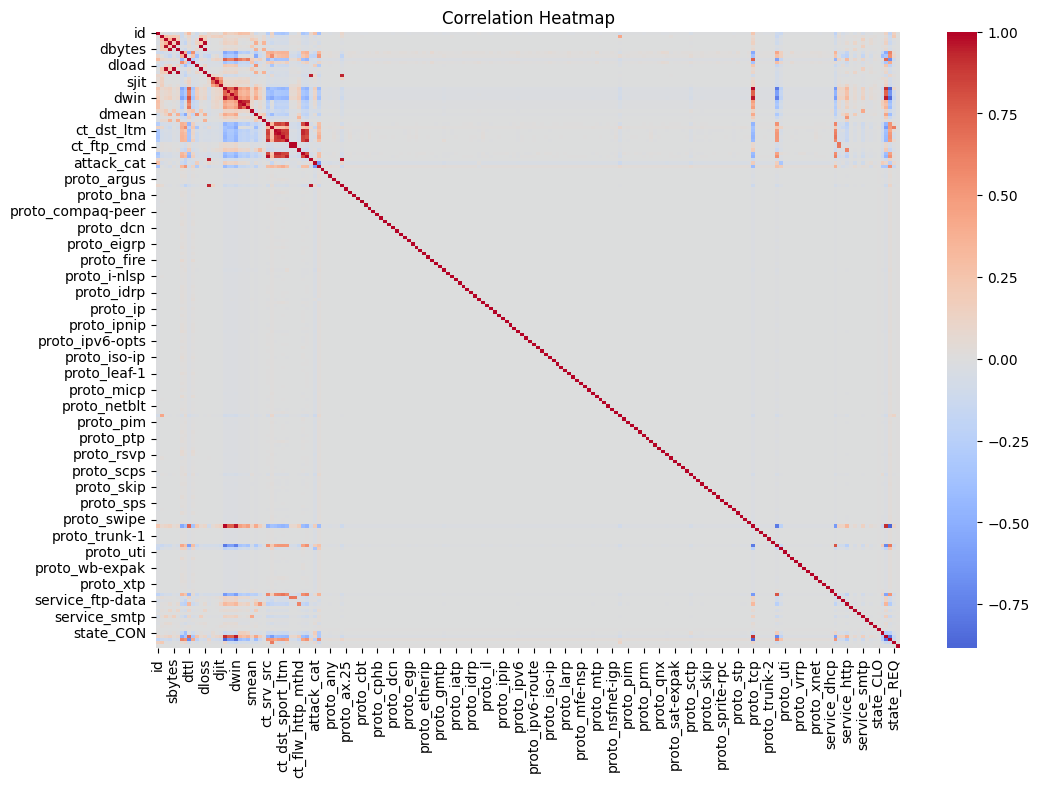

In [ ]:
corr = data_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
correlation_with_label = corr['label'].sort_values(ascending=False)
print("\nTop 10 correlated features with label:\n", correlation_with_label.head(10))


Top 10 correlated features with label:
 label               1.000000
state_INT           0.538576
sttl                0.504159
ct_dst_sport_ltm    0.393668
service_dns         0.363961
ct_src_dport_ltm    0.341513
rate                0.328629
ct_state_ttl        0.318517
ct_srv_dst          0.292931
ct_srv_src          0.290195
Name: label, dtype: float64


In [ ]:
top_features = correlation_with_label.index[:10]  # Top features for anomaly detection
numeric_features = data_encoded[top_features].select_dtypes(include=[np.number])

In [ ]:
z_scores = np.abs(stats.zscore(numeric_features))
threshold = 3
anomalies = (z_scores > threshold).any(axis=1)
data_encoded['anomaly'] = anomalies
print("\nNumber of anomalies detected:", data_encoded['anomaly'].sum())


Number of anomalies detected: 7808


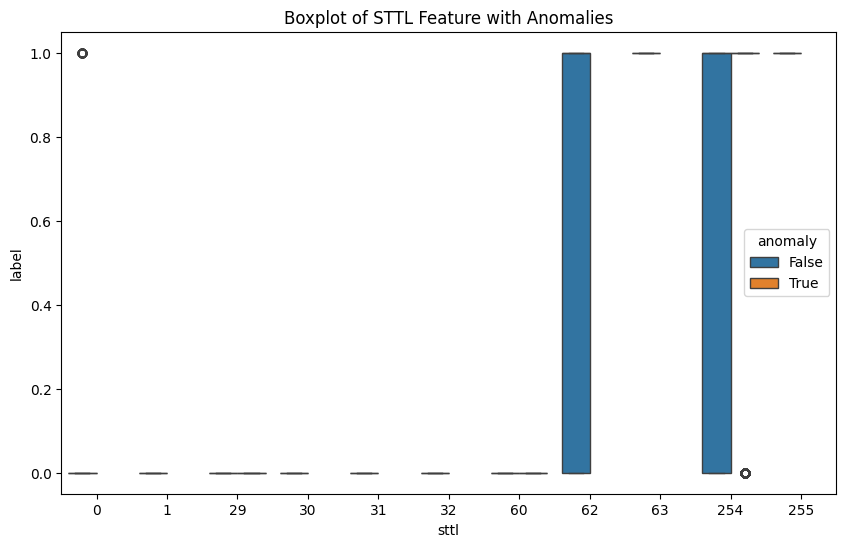

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_encoded['sttl'], y=data_encoded['label'], hue=data_encoded['anomaly'])
plt.title("Boxplot of STTL Feature with Anomalies")
plt.show()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_prepared, y)

RandomForestClassifier(random_state=42)

In [ ]:
data_test_super = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_testing-set.csv')
categorical_features = ['proto', 'service', 'state']
numerical_features= data_test.drop(columns = [ 'id', 'proto' , 'service' , 'state', 'attack_cat']).columns
encoder = OneHotEncoder (sparse_output = False, drop = 'first')
encoder_categorical = encoder.fit_transform(data[categorical_features])

scalar = StandardScaler ()
scaled_numerical = scalar.fit_transform(data[numerical_features])
X_test_super = np.hstack((encoder_categorical, scaled_numerical))
y_test_super = data_test ['attack_cat'].values

In [ ]:
y_pred = rf_model.predict(X_test_super)


In [ ]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test_super: {y_test_super.shape}")
print(f"Shape of y_pred: {y_pred.shape}")


Shape of X_test: (82332, 188)
Shape of y_test_super: (175341,)
Shape of y_pred: (82332,)


In [ ]:
y_test_super = y[:82332]

In [ ]:
print(f"Accuracy: {accuracy_score(y_test_super, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test_super, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_super, y_pred)}")


Accuracy: 0.9360880338143128
Classification Report:
                precision    recall  f1-score   support

      Analysis       1.00      0.09      0.16       677
      Backdoor       1.00      0.10      0.18       583
           DoS       0.57      0.83      0.68      4089
      Exploits       0.85      0.80      0.82     11132
       Fuzzers       0.83      0.87      0.85      6062
       Generic       1.00      1.00      1.00     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.99      0.91      0.95      3496
     Shellcode       1.00      1.00      1.00       378
         Worms       0.98      1.00      0.99        44

      accuracy                           0.94     82332
     macro avg       0.92      0.76      0.76     82332
  weighted avg       0.95      0.94      0.93     82332

Confusion Matrix:
[[   58     0   149   257   213     0     0     0     0     0]
 [    0    57    42   267   213     0     0     4     0     0]
 [    0     0  34

In [ ]:
feature_importances = rf_model.feature_importances_
print(f"Feature Importances: {feature_importances}")


Feature Importances: [1.60247913e-05 1.89320998e-05 7.61332546e-05 3.36343418e-05
 2.24897654e-05 1.32976934e-03 1.76440181e-05 3.98724441e-05
 1.56603978e-05 1.56612052e-05 1.45756993e-05 1.64164486e-05
 2.25644901e-05 1.64330830e-05 1.64047977e-05 1.55523872e-05
 1.94049794e-05 2.12021410e-05 1.94029575e-05 2.28883446e-05
 1.54851753e-05 1.72730431e-05 2.48055917e-05 1.73283271e-05
 2.88127654e-05 1.82605242e-05 1.86215691e-05 2.73211854e-05
 1.58344228e-05 1.69456589e-05 2.06953474e-05 1.12646456e-04
 2.23109332e-05 1.44802860e-05 1.87073461e-05 1.96267231e-05
 1.97063599e-05 1.15772115e-05 1.95342871e-05 2.28205504e-05
 6.67840332e-05 4.34394897e-05 2.03489999e-05 3.27389195e-05
 1.42938422e-05 1.37940462e-05 1.63887540e-05 1.72740055e-05
 2.06190229e-05 1.81057006e-05 9.40001275e-05 2.10417343e-05
 2.16218407e-05 1.41055920e-05 1.34814179e-05 1.55323309e-05
 1.39580823e-05 1.94595103e-05 1.74119704e-05 1.82982248e-05
 1.82136086e-05 1.88137179e-05 1.63468884e-05 2.54179032e-05
 1.

In [ ]:
with torch.no_grad():  # Disable gradient calculation
    y_pred_contrastive = model(X_test_tensor)

# If it's a classification task, you may need to apply a softmax or argmax
y_pred_contrastive = torch.argmax(y_pred_contrastive, dim=1).cpu().numpy()

# Predictions from Supervised (Random Forest)
y_pred_rf = rf_model.predict(X_test)


In [ ]:
y_pred_contrastive

array([115, 115, 115, ...,  32,  32, 185])

In [ ]:
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]


In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during inference
    outputs = model(X_test_tensor)  # Get the raw logits (for a batch of inputs)

# Apply softmax to get probabilities
y_pred_contrastive_proba = F.softmax(outputs, dim=1).numpy()  # Convert logits to probabilities


y_pred_contrastive_proba = y_pred_contrastive_proba[:, 1]

In [ ]:
y_pred_contrastive_proba

array([0.00373232, 0.00351513, 0.0036473 , ..., 0.00289496, 0.00289496,
       0.00377373], dtype=float32)

In [ ]:
y_pred_rf_proba[:800]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
y_pred_ensemble = (y_pred_contrastive_proba + y_pred_rf_proba) / 2

In [ ]:
weight_contrastive = 0.6
weight_rf = 0.4

In [ ]:
y_pred_ensemble = (weight_contrastive * y_pred_contrastive) + (weight_rf * y_pred_rf_proba)

In [ ]:
y_pred_ensemble

array([ 69. ,  69. ,  69. , ...,  19.2,  19.2, 111. ])

In [ ]:
y_pred_final = (y_pred_ensemble > 0.7).astype(int)

In [ ]:
y_pred_final[:700]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
ensemble_accuracy = accuracy_score(y_test_super, y_pred_final)
print(f'Ensemble Accuracy: {ensemble_accuracy}')

Ensemble Accuracy: 0.0


In [ ]:
import torch
import torch.nn.functional as F

# Assuming model is your contrastive learning model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    logits = model(X_test_tensor)  # Get the raw logits

# Apply softmax to convert logits to probabilities
y_pred_contrastive_proba = F.softmax(logits, dim=1).numpy()


In [ ]:
y_pred_rf_proba = rf_model.predict_proba(X_test)
print(y_pred_rf_proba.shape)


(82332, 10)


In [ ]:
# For binary classification, using the probabilities for the positive class (index 1 for 2D arrays)
if len(y_pred_contrastive_proba.shape) == 2:
    y_pred_contrastive_proba = y_pred_contrastive_proba[:, 1]  # Use class 1 probabilities

# If Random Forest predictions are already probabilities
if len(y_pred_rf_proba.shape) == 2:
    y_pred_rf_proba = y_pred_rf_proba[:, 1]  # Use class 1 probabilities

# Now combine probabilities
y_pred_ensemble = 0.5 * y_pred_contrastive_proba + 0.5 * y_pred_rf_proba

# Apply a threshold to convert probabilities to class labels
y_pred_final = (y_pred_ensemble > 0.5).astype(int)


In [ ]:
print("Shape of contrastive proba:", y_pred_contrastive_proba.shape)
print("Shape of RF proba:", y_pred_rf_proba.shape)


Shape of contrastive proba: (82332,)
Shape of RF proba: (82332,)


In [ ]:
# Assuming both are 1D arrays containing probabilities for class 1
y_pred_contrastive_proba = y_pred_contrastive_proba
y_pred_rf_proba = y_pred_rf_proba

# Combine the probabilities
y_pred_ensemble = 0.5 * y_pred_contrastive_proba + 0.5 * y_pred_rf_proba

# Apply a threshold to convert to class labels
y_pred_final = (y_pred_ensemble > 0.00).astype(int)



In [ ]:
print(np.min(y_pred_contrastive_proba), np.max(y_pred_contrastive_proba))
print(np.min(y_pred_rf_proba), np.max(y_pred_rf_proba))


1.915304e-07 0.004461867
0.0 0.87


In [ ]:
y_pred_final = (y_pred_ensemble > 0.3).astype(int)  # Try with a lower threshold

In [ ]:
y_pred_ensemble = 0.7 * y_pred_contrastive_proba + 0.3 * y_pred_rf_proba


In [ ]:
y_pred_ensemble[:80]

array([0.00261262, 0.00246059, 0.00255311, 0.00259691, 0.00242946,
       0.00258647, 0.0024161 , 0.00252225, 0.00204   , 0.00204   ,
       0.00204   , 0.00204   , 0.00244641, 0.00240765, 0.00243155,
       0.00254382, 0.00266693, 0.00246793, 0.00217178, 0.00229723,
       0.00241203, 0.00264275, 0.00253234, 0.00236479, 0.0026821 ,
       0.00250193, 0.00259443, 0.00214674, 0.00263789, 0.00237957,
       0.0026117 , 0.00233962, 0.00234566, 0.00259555, 0.00236297,
       0.00228727, 0.00233692, 0.00202934, 0.00202934, 0.00202934,
       0.00228025, 0.00202934, 0.00235627, 0.0023402 , 0.00238074,
       0.00225879, 0.00233336, 0.00233796, 0.00228778, 0.0023162 ,
       0.00237078, 0.00236578, 0.00257265, 0.00257265, 0.00257265,
       0.00234275, 0.00237123, 0.00262271, 0.00262271, 0.00262271,
       0.0026197 , 0.00261951, 0.0026197 , 0.0026197 , 0.00261951,
       0.00261951, 0.00235634, 0.00254646, 0.00254842, 0.00257547,
       0.00257692, 0.00257547, 0.0022966 , 0.00257692, 0.00257

In [ ]:
y_pred_final = (y_pred_ensemble > 0.1).astype(int)  # Lower threshold to 0.1


In [ ]:
print(type(y_test_super))
print(type(y_pred_final))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
y_pred_final = (y_pred_ensemble > 0.1).astype(int)

In [ ]:
import numpy as np

# Using numpy to map the values
y_test_super = np.where(y_test_super == 'positive', 1, 0)

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test_super, y_pred_final))

Accuracy: 0.9993076810960502
